# [ Glass Type Classification with OVR]
- train ratio : 0.1, 0.3, 0.5, 0.7
- metric : accuracy, precision, recall, F1-score
- dataset : glass.csv

# 1. Import Libraries & Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
gl = pd.read_csv('glass.csv',header=None)
gl = gl.drop(0,axis=1)
gl = gl.sample(frac=1)
gl.columns = ['Ri','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type']

In [3]:
gl.head()

,Ri,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
72,1.51593,13.09,3.59,1.52,73.10,0.67,7.83,0.0,0.00,2
13,1.51748,12.86,3.56,1.27,73.21,0.54,8.38,0.0,0.17,1
89,1.51640,12.55,3.48,1.87,73.23,0.63,8.08,0.0,0.09,2
173,1.52043,13.38,0.00,1.40,72.25,0.33,12.50,0.0,0.00,5
63,1.52227,14.17,3.81,0.78,71.35,0.00,9.69,0.0,0.00,1


In [4]:
gl.Type.value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

In [5]:
gl.shape

(214, 10)

### into 2 Dimensional 
- using Principal Component Analysis

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [7]:
pca.fit(gl.iloc[:,0:10])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [8]:
pca.explained_variance_ratio_.sum()

0.8108102743598888

In [9]:
X1 = pca.fit_transform(gl.iloc[:,0:10])[:,0]
X2 = pca.fit_transform(gl.iloc[:,0:10])[:,1]                       
new_data = pd.DataFrame({'X1':X1,'X2':X2,'class':gl.iloc[:,-1]})

In [10]:
new_data.head()

,X1,X2,class
72,-1.246995,-1.095024,2
13,-2.065570,-0.295497,1
89,-1.206158,-0.773854,2
173,3.466450,3.534764,5
63,-2.007860,0.788674,1


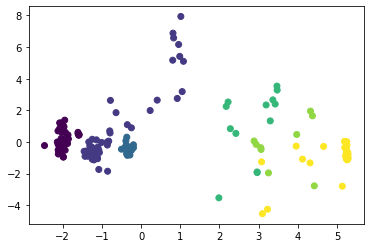

In [11]:
plt.scatter(new_data['X1'], new_data['X2'], c=new_data['class'])
plt.show()

# 2. Define Functions

- 1) train_test_split
- 2) matrix multiplication
- 3) sigmoid
- 4) standard scaler
- 5) loss function

In [12]:
def train_test_split(data,test_ratio):
    
    data.iloc[:,[0,1]] = standard_scaler(data.iloc[:,[0,1]])
    test_index = np.random.choice(len(data),int(len(data)*test_ratio),replace=False)
    train = data[~data.index.isin(test_index)]
    test = data[data.index.isin(test_index)]
    
    train_X = np.array(train)[:,[0,1]]
    train_y = np.array(train)[:,[2]].flatten()
    test_X = np.array(test)[:,[0,1]]
    test_y = np.array(test)[:,[2]].flatten()
    return train_X,train_y, test_X,test_y

In [13]:
def mul(W,b,x):
    return np.dot(x,W)+b

def sigmoid(x):    
    k = 1 / (1 + np.exp(-x))
    return k[:,0]

In [14]:
def standard_scaler(x):
    mean = np.mean(x)
    std = np.std(x)
    return (x-mean)/std

In [15]:
def loss_func(y_hat,y):
    total_loss = np.mean(y*np.log(y_hat+(1e-6)) + (1-y)*np.log(1-y_hat+(1e-6)))
    return -total_loss

# 3. Train Model

### Logistic Regression

In [16]:
def logreg(x,y,epoch,lr):
    W = np.random.rand(x.shape[1],1)
    b = np.random.rand(1)
    
    for ep in range(epoch+1):
        Z = mul(W,b,x)
        y_hat = sigmoid(Z)
        loss = loss_func(y_hat,y)
        dw = np.matmul(x.T,y_hat-y)/x.shape[0]
        db = np.sum(y_hat-y)
        
        W = W-lr*dw.reshape(-1,1)
        b = b-lr*db
        
        if ep % 20 == 0:
            print('epoch :',ep,' loss :',loss)
            
    return W,b

# 4. Prediction

### train

In [17]:
def predict(test_X,W,b):
    result = sigmoid(np.dot(test_X, W) + b)
    return result

In [18]:
def Metrics(pred,actual):
    TP,TN,FP,FN = 0,0,0,0
    for i in range(len(pred)):
        if pred[i]*actual[i]==1:
            TP +=1
        elif pred[i]>actual[i]:
            FP +=1
        elif pred[i]<actual[i]:
            FN +=1
        else:
            TN +=1
    
    accuracy = (TP+TN) / (TP+TN+FP+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    F1_score = 2*(precision*recall)/(precision+recall)
    return accuracy,precision,recall,F1_score

In [19]:
new_data['class'].unique()

array([2, 1, 5, 3, 6, 7], dtype=int64)

In [20]:
def OVR(data,test_ratio,epoch,lr):
    train_x,train_y,test_x,test_y = train_test_split(data,test_ratio)
    pred_result = []
    real_result = []
    for index in data['class'].unique():
        train_y2 = (train_y == index).astype(int)        
        test_y2 = (test_y == index).astype(int)
        W,b = logreg(train_x,train_y2,epoch,lr)
        y_pred = predict(test_x,W,b)
        pred_result.append(y_pred)
        real_result.append(test_y2)
    pred_OH = (pred_result == np.amax(pred_result,axis=0)).astype('int')
    act_OH = np.concatenate(real_result).ravel().reshape(data.iloc[:,-1].nunique(),-1)    
    return pred_OH,act_OH

In [21]:
prediction,actual = OVR(new_data,0.3,1000,0.01)

epoch : 0  loss : 0.9268306711358498
epoch : 20  loss : 0.8588922980255772
epoch : 40  loss : 0.8395200398517075
epoch : 60  loss : 0.8214687138506367
epoch : 80  loss : 0.8046869652902364
epoch : 100  loss : 0.7891187467109749
epoch : 120  loss : 0.7747044656935533
epoch : 140  loss : 0.7613822609896916
epoch : 160  loss : 0.7490891477084815
epoch : 180  loss : 0.7377620104388042
epoch : 200  loss : 0.7273384367558129
epoch : 220  loss : 0.7177573940721566
epoch : 240  loss : 0.7089597601648292
epoch : 260  loss : 0.7008887222317749
epoch : 280  loss : 0.6934900615217235
epoch : 300  loss : 0.6867123410213838
epoch : 320  loss : 0.6805070129331863
epoch : 340  loss : 0.6748284612064496
epoch : 360  loss : 0.6696339925600544
epoch : 380  loss : 0.6648837875142215
epoch : 400  loss : 0.6605408210997243
epoch : 420  loss : 0.656570761229677
epoch : 440  loss : 0.6529418512447911
epoch : 460  loss : 0.6496247818862131
epoch : 480  loss : 0.6465925568986215
epoch : 500  loss : 0.6438203555

epoch : 300  loss : 0.10940360333286828
epoch : 320  loss : 0.10923182735564337
epoch : 340  loss : 0.10906283709663252
epoch : 360  loss : 0.108896587410453
epoch : 380  loss : 0.10873303386448441
epoch : 400  loss : 0.10857213272578202
epoch : 420  loss : 0.10841384094802363
epoch : 440  loss : 0.10825811615874618
epoch : 460  loss : 0.10810491664699985
epoch : 480  loss : 0.10795420135146341
epoch : 500  loss : 0.10780592984902256
epoch : 520  loss : 0.10766006234379305
epoch : 540  loss : 0.10751655965656369
epoch : 560  loss : 0.10737538321463169
epoch : 580  loss : 0.10723649504200343
epoch : 600  loss : 0.10709985774993366
epoch : 620  loss : 0.10696543452777971
epoch : 640  loss : 0.106833189134146
epoch : 660  loss : 0.10670308588829888
epoch : 680  loss : 0.10657508966183082
epoch : 700  loss : 0.10644916587055585
epoch : 720  loss : 0.10632528046661889
epoch : 740  loss : 0.10620339993080362
epoch : 760  loss : 0.10608349126502377
epoch : 780  loss : 0.10596552198498481
epoc

In [22]:
def confusion_matrix(actual,prediction):
    n = actual.shape[0]
    conf_mat = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            conf_mat[i][j] += len(np.intersect1d(np.nonzero(actual[i]),np.nonzero(prediction[j])))        
    return conf_mat

In [23]:
glass_con = confusion_matrix(actual, prediction)
glass_con

array([[ 6., 13.,  0.,  0.,  0.,  0.],
       [ 7., 16.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  1.],
       [ 5.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  5.],
       [ 0.,  0.,  0.,  0.,  0., 10.]])

# Wine dataset

In [24]:
from sklearn.datasets import load_wine

In [25]:
data = load_wine()

In [26]:
X = data.data
y = data.target

In [27]:
wine = pd.DataFrame(X)
wine['type'] = y
wine = wine.sample(frac=1)

In [28]:
wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,type
97,12.29,1.41,1.98,16.0,85.0,2.55,2.50,0.29,1.77,2.90,1.23,2.74,428.0,1
56,14.22,1.70,2.30,16.3,118.0,3.20,3.00,0.26,2.03,6.38,0.94,3.31,970.0,0
59,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0,1
81,12.72,1.81,2.20,18.8,86.0,2.20,2.53,0.26,1.77,3.90,1.16,3.14,714.0,1
130,12.86,1.35,2.32,18.0,122.0,1.51,1.25,0.21,0.94,4.10,0.76,1.29,630.0,2


### dimension reduction with PCA

In [29]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)

In [30]:
pca2.fit(wine.iloc[:,0:13])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [31]:
pca2.explained_variance_ratio_.sum()

0.9998271461166032

In [32]:
X1 = pca2.fit_transform(wine.iloc[:,0:13])[:,0]
X2 = pca2.fit_transform(wine.iloc[:,0:13])[:,1]                       
wine2 = pd.DataFrame({'X1':X1,'X2':X2,'class':wine.iloc[:,-1]})

In [33]:
wine2['class'].value_counts()

1    71
0    59
2    48
Name: class, dtype: int64

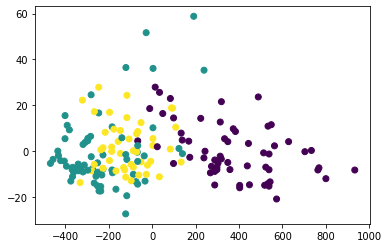

In [34]:
plt.scatter(wine2['X1'], wine2['X2'], c=wine2['class'])
plt.show()

In [35]:
prediction2,actual2 = OVR(wine2,0.3,3000,0.1)

epoch : 0  loss : 0.8113730768886772
epoch : 20  loss : 0.8909897351844835
epoch : 40  loss : 0.8077517078345119
epoch : 60  loss : 0.7360473158176558
epoch : 80  loss : 0.6491199176104304
epoch : 100  loss : 0.5585284689709566
epoch : 120  loss : 0.4867653239808993
epoch : 140  loss : 0.4424551229968402
epoch : 160  loss : 0.42235582827187645
epoch : 180  loss : 0.41655575665393074
epoch : 200  loss : 0.41495635086412985
epoch : 220  loss : 0.41398381077003904
epoch : 240  loss : 0.41319577834650884
epoch : 260  loss : 0.4125423447754751
epoch : 280  loss : 0.41199708655607076
epoch : 300  loss : 0.41153973780916636
epoch : 320  loss : 0.4111543990257564
epoch : 340  loss : 0.4108284496013392
epoch : 360  loss : 0.41055177206946325
epoch : 380  loss : 0.4103161861498518
epoch : 400  loss : 0.41011502840232794
epoch : 420  loss : 0.40994283520106206
epoch : 440  loss : 0.409795100446869
epoch : 460  loss : 0.40966808824927914
epoch : 480  loss : 0.4095586866281432
epoch : 500  loss : 0

epoch : 1920  loss : 0.17043470610520553
epoch : 1940  loss : 0.17041114970112473
epoch : 1960  loss : 0.17038842260550877
epoch : 1980  loss : 0.17036649226538175
epoch : 2000  loss : 0.17034532758259763
epoch : 2020  loss : 0.17032489883904559
epoch : 2040  loss : 0.17030517762627334
epoch : 2060  loss : 0.17028613677922974
epoch : 2080  loss : 0.17026775031385294
epoch : 2100  loss : 0.17024999336825064
epoch : 2120  loss : 0.17023284214723752
epoch : 2140  loss : 0.17021627387001104
epoch : 2160  loss : 0.17020026672076466
epoch : 2180  loss : 0.17018479980205145
epoch : 2200  loss : 0.17016985309072305
epoch : 2220  loss : 0.1701554073962839
epoch : 2240  loss : 0.17014144432150893
epoch : 2260  loss : 0.17012794622518704
epoch : 2280  loss : 0.17011489618685852
epoch : 2300  loss : 0.17010227797342628
epoch : 2320  loss : 0.17009007600752818
epoch : 2340  loss : 0.1700782753375647
epoch : 2360  loss : 0.17006686160928408
epoch : 2380  loss : 0.17005582103883368
epoch : 2400  loss

In [42]:
actual2

array([[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1]])

In [43]:
prediction2

array([[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 1],
       [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [36]:
wine_con = confusion_matrix(actual2, prediction2)
wine_con

array([[20.,  1.,  0.],
       [ 1., 15.,  0.],
       [16.,  0.,  0.]])

In [37]:
actual2

array([[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1]])

# Micro F1 & Macro F1

In [38]:
def f1_scores(con,score): 
    # score = 0 : micro / score =1 : macro / score = 2 : weighted macro
    
    # (1) Micro F1
    if score==0: 
        return np.diag(con).sum()/con.sum()
    rec,pre,f1 = [],[],[]
    
    for i in range(con.shape[0]):
        recall = con[i][i] / con[i].sum()
        precision = con[i][i] / con[:,i].sum()
        f1_score = 2*recall*precision / (recall+precision)
        rec.append(recall)
        pre.append(precision)
        f1.append(f1_score)
    
    # (2) Macro F1
    if score==1:
        return np.average(f1)
    
    # (3) Weighted Macro F1
    elif score==2:
        w = [con[x].sum() for x in range(con.shape[0])]
        return np.average(f1,weights=w)

In [39]:
print('Wine Dataset')
print('Micro F1 :',f1_scores(wine_con,0).round(3))
print('Macro F1 (Average) :',f1_scores(wine_con,1).round(3))
print('Macro F1 (Weighted Average) :',f1_scores(wine_con,2).round(3))

Wine Dataset
Micro F1 : 0.66
Macro F1 (Average) : nan
Macro F1 (Weighted Average) : nan


C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [41]:
f1_scores(wine_con,1)

C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


nan